# 02 - Parks pro Bezirk

## Ziel
Ermittelt Parkindikatoren pro Stadtbezirk auf OSM-Basis.

## Inputs
- data/interim/muc_bezirke_bev_clean.geojson, OSM-Parks

## Outputs
- data/processed/muc_bezirke_parks.geojson

## Ausfuehrung
- Von oben nach unten ausfuehren (Restart & Run All).
- Dieses Notebook ist Teil der Pipeline 00 -> 05.


# Notebook 02 – Parks & Grünflächen pro Stadtbezirk in München

Ziel dieses Notebooks ist es, auf Basis von OpenStreetMap-Daten parkbezogene Kennzahlen
für die Münchner Stadtbezirke abzuleiten (u. a. Anzahl Parks, Parkfläche pro Einwohner,
Anteil der Parkfläche an der Bezirksfläche). Der bereinigte Stadtbezirks-Datensatz aus
Notebook 01 dient dabei als räumlicher Basislayer.

## Setup

In [1]:
import geopandas as gpd
import osmnx as ox
from pathlib import Path
import matplotlib.pyplot as plt

BASE_DIR = Path("..")
INTERIM_DIR = BASE_DIR / "data" / "interim"
PROCESSED_DIR = BASE_DIR / "data" / "processed"
INTERIM_DIR, PROCESSED_DIR


(PosixPath('../data/interim'), PosixPath('../data/processed'))

## Basisdatensatz: Stadtbezirke mit Bevölkerungsdaten

Hier wird der in Notebook 01 bereinigte Stadtbezirks-Datensatz `gdf_clean` eingelesen
und als räumlicher Basislayer verwendet.

In [2]:
gdf_bezirke = gpd.read_file(INTERIM_DIR / "muc_bezirke_bev_clean.geojson")
gdf_bezirke.head()


,bez_nr,name,stadtbezirk,einwohner,flaeche_ha,einwohnerdichte,geometry
0,1,Altstadt-Lehel,Altstadt - Lehel,20876,31459.0,66,"POLYGON ((692704.77 5336941.154, 692682.921 53..."
1,2,Ludwigsvorstadt-Isarvorstadt,Ludwigsvorstadt - Isarvorstadt,50081,44017.0,114,"POLYGON ((689722.841 5335359.37, 689570.385 53..."
2,3,Maxvorstadt,Maxvorstadt,52434,42982.0,122,"POLYGON ((690674.877 5336921.715, 690657.282 5..."
3,4,Schwabing-West,Schwabing West,68610,43633.0,157,"POLYGON ((691821.837 5339259.125, 691767.291 5..."
4,5,Au-Haidhausen,Au - Haidhausen,63972,42200.0,152,"POLYGON ((693021.981 5335306.773, 693021.084 5..."


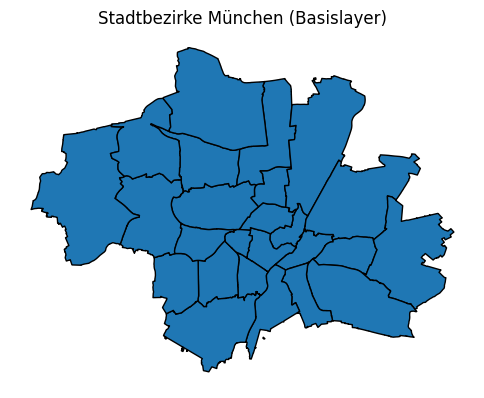

In [3]:
gdf_bezirke.plot(edgecolor="black", figsize=(6, 6))
plt.title("Stadtbezirke München (Basislayer)")
plt.axis("off")
plt.show()


## Parks aus OpenStreetMap laden

In diesem Schritt werden alle OSM-Objekte mit `leisure = "park"` für das Stadtgebiet
München abgefragt und in das gleiche Koordinatensystem wie der Bezirkslayer transformiert.

In [4]:
place_name = "München, Deutschland"
park_tags = {"leisure": "park"}

# Parks aus OSM abfragen
gdf_parks = ox.features_from_place(place_name, park_tags)

# CRS an Bezirkslayer anpassen
gdf_parks = gdf_parks.to_crs(gdf_bezirke.crs)

gdf_parks[["name", "geometry"]].head()
len(gdf_parks)


954

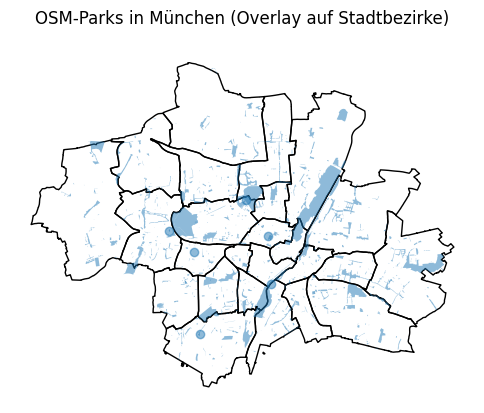

In [5]:
ax = gdf_bezirke.plot(edgecolor="black", facecolor="none", figsize=(6, 6))
gdf_parks.plot(ax=ax, alpha=0.5)
plt.title("OSM-Parks in München (Overlay auf Stadtbezirke)")
plt.axis("off")
plt.show()


## Räumliche Zuordnung der Parks zu Stadtbezirken

Mittels `gpd.sjoin` werden die Parkgeometrien den Stadtbezirken zugeordnet, sodass
jeder Park eine Bezirksnummer (`bez_nr`) erhält.

In [6]:
# Nur Park-Name und Geometrie behalten
parks = gdf_parks[["name", "geometry"]].copy()

# Räumlicher Join: welcher Park fällt in welchen Bezirk?
parks_in_bezirke = gpd.sjoin(
    parks,
    gdf_bezirke[["bez_nr", "geometry"]],
    how="inner",
    predicate="intersects"
)

parks_in_bezirke[["name", "bez_nr"]].head(10)


name  \
element  id                                                               
node     5141107389                                         Rosengarten   
         6521903324                   Gemeinschaftsgarten o'pflanzt is!   
         9127973599                                          Hühnerberg   
         10315621109                                       Laimer Anger   
         12357383401  Garten der Städtischen Galerie im Lenbachhaus ...   
         13167237558                                                NaN   
relation 29600                                            Weißenseepark   
         117906                                      Hinterbrühler Park   
         146438                                                     NaN   
         151288                                                     NaN   

                      bez_nr  
element  id                   
node     5141107389       18  
         6521903324        9  
         9127973599       19  
         10315621109      25  
         12357383401       3  
         13167237558      21  
relation 29600            17  
         117906           19  
         146438           15  
         151288           21

## Aggregation auf Bezirksebene & Ableitung von Park-Kennzahlen

In [7]:
# Anzahl Parks je Bezirk
parks_per_bez = (
    parks_in_bezirke
    .groupby("bez_nr")
    .size()
    .reset_index(name="parks_count")
)


# Parkfläche je Bezirk (Fläche der Parkgeometrie)
parks_in_bezirke["park_area"] = parks_in_bezirke.geometry.area

parks_area_per_bez = (
    parks_in_bezirke
    .groupby("bez_nr")["park_area"]
    .sum()
    .reset_index()
)


# In Hektar (ha) umrechnen (wenn CRS in Meter -> m²)
parks_area_per_bez["parks_area_ha"] = parks_area_per_bez["park_area"] / 10_000
parks_area_per_bez = parks_area_per_bez[["bez_nr", "parks_area_ha"]]


In [8]:
# Mit Bezirksdaten zusammenführen
gdf_active = gdf_bezirke.merge(parks_per_bez, on="bez_nr", how="left")
gdf_active = gdf_active.merge(parks_area_per_bez, on="bez_nr", how="left")

# Bezirke ohne Parks auf 0 setzen
gdf_active[["parks_count", "parks_area_ha"]] = gdf_active[["parks_count", "parks_area_ha"]].fillna(0)

# Ableitung der Kennzahlen
gdf_active["parks_pro_1000_einw"] = gdf_active["parks_count"] / gdf_active["einwohner"] * 1000
gdf_active["parks_area_ha_pro_1000_einw"] = gdf_active["parks_area_ha"] / gdf_active["einwohner"] * 1000
gdf_active["parks_area_anteil_prozent"] = gdf_active["parks_area_ha"] / gdf_active["flaeche_ha"] * 100

# Ergebnis anschauen
gdf_active[["bez_nr", "name", "parks_count", "parks_area_ha","parks_pro_1000_einw", "parks_area_anteil_prozent"]].head(30)


,bez_nr,name,parks_count,parks_area_ha,parks_pro_1000_einw,parks_area_anteil_prozent
0,1,Altstadt-Lehel,27,412.764810,1.293351,1.312072
1,2,Ludwigsvorstadt-Isarvorstadt,21,158.267122,0.419321,0.359559
2,3,Maxvorstadt,35,424.167862,0.667506,0.986850
3,4,Schwabing-West,23,177.474001,0.335228,0.406743
4,5,Au-Haidhausen,36,82.649221,0.562746,0.195851
5,6,Sendling,19,160.100229,0.463392,0.406459
6,7,Sendling-Westpark,35,142.506423,0.562339,0.182352
7,8,Schwanthalerhöhe,10,13.358433,0.348626,0.064524
8,9,Neuhausen-Nymphenburg,76,433.357830,0.745822,0.335549
9,10,Moosach,45,77.851084,0.803356,0.070176


**Zwischenfazit:**  
Für jeden Stadtbezirk liegen nun neben Einwohnerzahl und Fläche auch parkbezogene
Kennzahlen vor: Anzahl der Parks, gesamte Parkfläche, Parks pro 1.000 Einwohner
und Anteil der Parkfläche an der Bezirksfläche.

## Räumliche Verteilung: Parks pro 1.000 Einwohner

Im folgenden Choroplethenplot wird dargestellt, wie viele Parks pro 1.000 Einwohner
in den jeweiligen Stadtbezirken vorhanden sind.

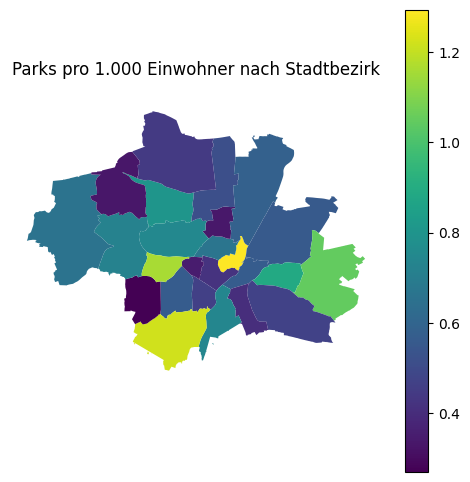

In [9]:
gdf_active.plot(column="parks_pro_1000_einw", legend=True, figsize=(6, 6))
plt.title("Parks pro 1.000 Einwohner nach Stadtbezirk")
plt.axis("off")
plt.show()


**Interpretation (kurz):**

- Die Versorgung mit Parks pro 1.000 Einwohner ist räumlich ungleich verteilt:
  einige Bezirke erreichen Werte von über 1 Park pro 1.000 Einwohner, während
  andere deutlich darunter liegen.
- Tendenziell schneiden einige innenstadtnahe Bezirke besser ab, während in
  bestimmten Randbezirken trotz großer Flächen weniger Parks pro Einwohner
  zur Verfügung stehen.
- Diese Kennzahl wird im weiteren Verlauf mit anderen Infrastruktur- und
  Bevölkerungsmerkmalen kombiniert, um „aktivitätsfreundliche“ Stadtbezirke
  zu identifizieren.

## Verteilung der Kennzahlen 

### Parks pro 1.000 Einwohner - Histogramm & Boxplot

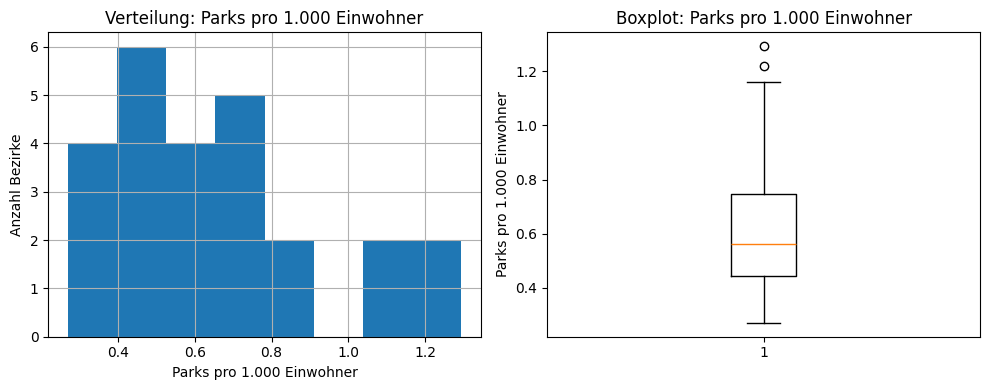

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Histogramm
gdf_active["parks_pro_1000_einw"].hist(ax=axes[0], bins=8)
axes[0].set_title("Verteilung: Parks pro 1.000 Einwohner")
axes[0].set_xlabel("Parks pro 1.000 Einwohner")
axes[0].set_ylabel("Anzahl Bezirke")

# Boxplot
axes[1].boxplot(gdf_active["parks_pro_1000_einw"], vert=True)
axes[1].set_title("Boxplot: Parks pro 1.000 Einwohner")
axes[1].set_ylabel("Parks pro 1.000 Einwohner")

plt.tight_layout()
plt.show()


**Interpretation:**

- Die meisten Stadtbezirke liegen in einem Korridor von etwa *0,4 bis 0,9* Parks pro 1.000 Einwohner.
- Einzelne Bezirke erreichen deutlich höhere Werte (oberes Ende des Boxplots) und sind damit im Vergleich überdurchschnittlich gut mit Parks je Einwohner versorgt.
- Es gibt auch Bezirke am unteren Rand der Verteilung, in denen deutlich weniger Parks pro Einwohner zur Verfügung stehen.


### Anteil der Parkfläche an der Bezirksfläche

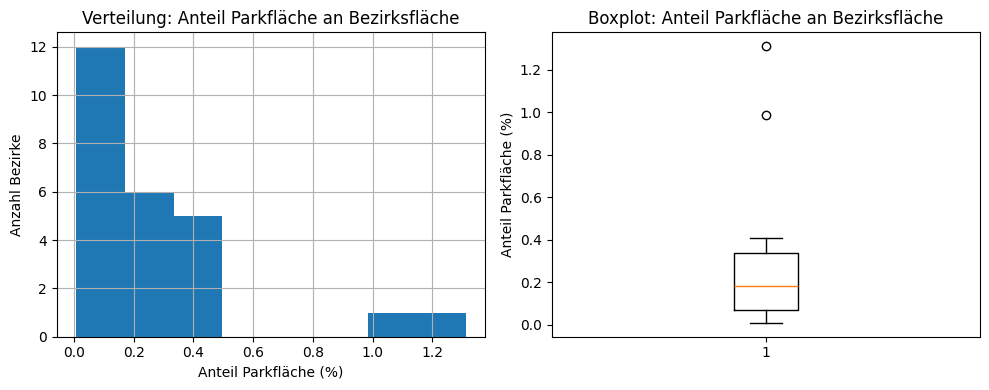

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Histogramm
gdf_active["parks_area_anteil_prozent"].hist(ax=axes[0], bins=8)
axes[0].set_title("Verteilung: Anteil Parkfläche an Bezirksfläche")
axes[0].set_xlabel("Anteil Parkfläche (%)")
axes[0].set_ylabel("Anzahl Bezirke")

# Boxplot
axes[1].boxplot(gdf_active["parks_area_anteil_prozent"], vert=True)
axes[1].set_title("Boxplot: Anteil Parkfläche an Bezirksfläche")
axes[1].set_ylabel("Anteil Parkfläche (%)")

plt.tight_layout()
plt.show()


**Interpretation:**

- Der prozentuale Anteil der Parkfläche an der Bezirksfläche ist insgesamt relativ niedrig und streut nur in einem begrenzten Bereich.
- Einige Bezirke weisen leicht erhöhte Anteile auf (obere Whisker im Boxplot), während andere Bezirke kaum Parkfläche im Verhältnis zur Gesamtfläche besitzen.
- In Kombination mit der Einwohnerdichte lässt sich später untersuchen, ob Bezirke mit dichter Bebauung kompensierend einen höheren Parkflächenanteil aufweisen.


## Ranking: Top- und Bottom-Bezirke

### Top 5 nach Parks pro 1.000 Einwohner

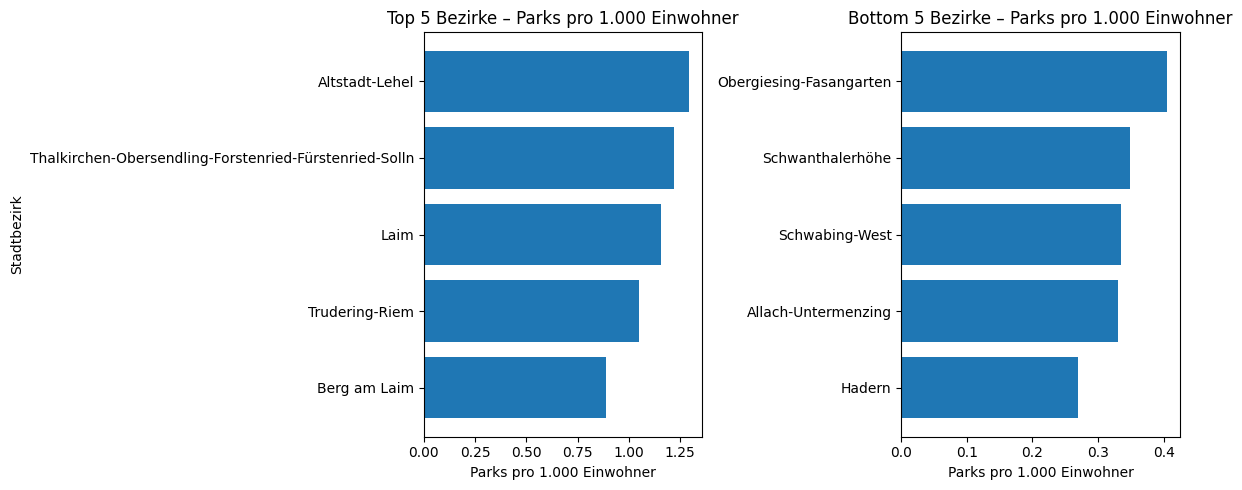

In [12]:
# Neu sortieren, damit es bei barh "von unten nach oben" logisch aussieht
top5 = (
    gdf_active[["name", "parks_pro_1000_einw"]]
    .sort_values("parks_pro_1000_einw", ascending=False)
    .head(5)
    .sort_values("parks_pro_1000_einw", ascending=True)   # für schöne Treppe bei barh
)

bottom5 = (
    gdf_active[["name", "parks_pro_1000_einw"]]
    .sort_values("parks_pro_1000_einw", ascending=True)
    .head(5)
    .sort_values("parks_pro_1000_einw", ascending=True)
)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Top 5 (horizontal)
axes[0].barh(top5["name"], top5["parks_pro_1000_einw"])
axes[0].set_title("Top 5 Bezirke – Parks pro 1.000 Einwohner")
axes[0].set_xlabel("Parks pro 1.000 Einwohner")
axes[0].set_ylabel("Stadtbezirk")

# Bottom 5 (horizontal)
axes[1].barh(bottom5["name"], bottom5["parks_pro_1000_einw"])
axes[1].set_title("Bottom 5 Bezirke – Parks pro 1.000 Einwohner")
axes[1].set_xlabel("Parks pro 1.000 Einwohner")
axes[1].set_ylabel("")

plt.tight_layout()
plt.show()


**Interpretation:**

- Die Top-5-Bezirke weisen rund *x–y* Parks pro 1.000 Einwohner auf und liegen damit deutlich über dem Mittelwert.
- Die Bottom-5-Bezirke erreichen deutlich geringere Werte; hier stehen den Einwohnerinnen und Einwohnern vergleichsweise wenig Parks pro Kopf zur Verfügung.
- Für die weitere Analyse sind insbesondere Kontrastpaare interessant (z. B. dicht besiedelte Bezirke mit gleichzeitig niedriger Parkausstattung).


## Export des erweiterten Datensatzes

Der Datensatz mit den parkbezogenen Kennzahlen wird für weitere Analysen
als GeoJSON-Datei abgelegt.

In [13]:
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)
out_path = PROCESSED_DIR / "muc_bezirke_parks.geojson"
gdf_active.to_file(out_path, driver="GeoJSON")
out_path


PosixPath('../data/processed/muc_bezirke_parks.geojson')

## Fazit (Notebook 02 – Parks)

In diesem Notebook wurde der Basisdatensatz der Münchner Stadtbezirke um
parkbezogene Kennzahlen erweitert. Auf Grundlage von OSM-Daten konnten
für jeden Bezirk unter anderem

- die Anzahl der Parks,
- die gesamte Parkfläche,
- Parks pro 1.000 Einwohner sowie
- der Anteil der Parkfläche an der Bezirksfläche

berechnet und kartiert werden. Erste Auswertungen zeigen, dass die
Versorgung mit Parks pro Einwohner räumlich ungleich verteilt ist und
sich klar unterscheidbare Gruppen von Bezirken abzeichnen. Der erzeugte
Datensatz `muc_bezirke_parks.geojson` dient als Grundlage für weitere
Active-City-Analysen (z. B. Einbezug von Sportstätten, ÖPNV oder Radwegen
sowie spätere Indexbildung bzw. Clustering).
